In [1]:
import os
os.chdir(os.path.expanduser("~/Projects/zimmer"))
import copy
import pickle

import numpy as np
np.random.seed(1234)

import matplotlib.pyplot as plt
plt.ion()

from tqdm import tqdm
from functools import partial

from zimmer.io import load_kato_data
import zimmer.plotting as zplt
from zimmer.observations import HierarchicalIndependentAutoRegressiveObservations
from zimmer.transitions import HierarchicalRecurrentTransitions, HierarchicalRecurrentOnlyTransitions

from ssm.models import HMM
from ssm.core import _HMM
from ssm.init_state_distns import InitialStateDistribution
from ssm.transitions import RecurrentTransitions, InputDrivenTransitions, StationaryTransitions, \
    NeuralNetworkRecurrentTransitions, RecurrentOnlyTransitions
from ssm.observations import IndependentAutoRegressiveObservations

from ssm.util import find_permutation, compute_state_overlap
from ssm.preprocessing import pca_with_imputation, trend_filter, standardize

In [2]:
# Load the data
ys, ms, z_trues, z_true_key, neuron_names = load_kato_data(include_unnamed=False, signal="dff")
ys = [trend_filter(y) for y in ys]


K_true = len(z_true_key)
N = ys[0].shape[1]
W = len(ys)
Ts = [y.shape[0] for y in ys]

Only including named neurons.
59 neurons across all 5 worms


In [3]:
K = 12  # number of inferred discrete states
D = 10   # dimensionality of continuous latent states
M = 0   # dimensionality of input

# Dimensionality reduction on $\Delta$F/F 

In [4]:
# Run PCA to get a 3d projection of the data
from scipy.ndimage import gaussian_filter1d
from ssm.preprocessing import pca_with_imputation
pca, xs = pca_with_imputation(D, ys, ms)
# xs = [gaussian_filter1d(x, 1, axis=0) for x in xs]
# dxs = [gaussian_filter1d(np.gradient(x, axis=0), 1, axis=0) for x in xs]

lim = 1.1 * abs(np.vstack(xs)).max()

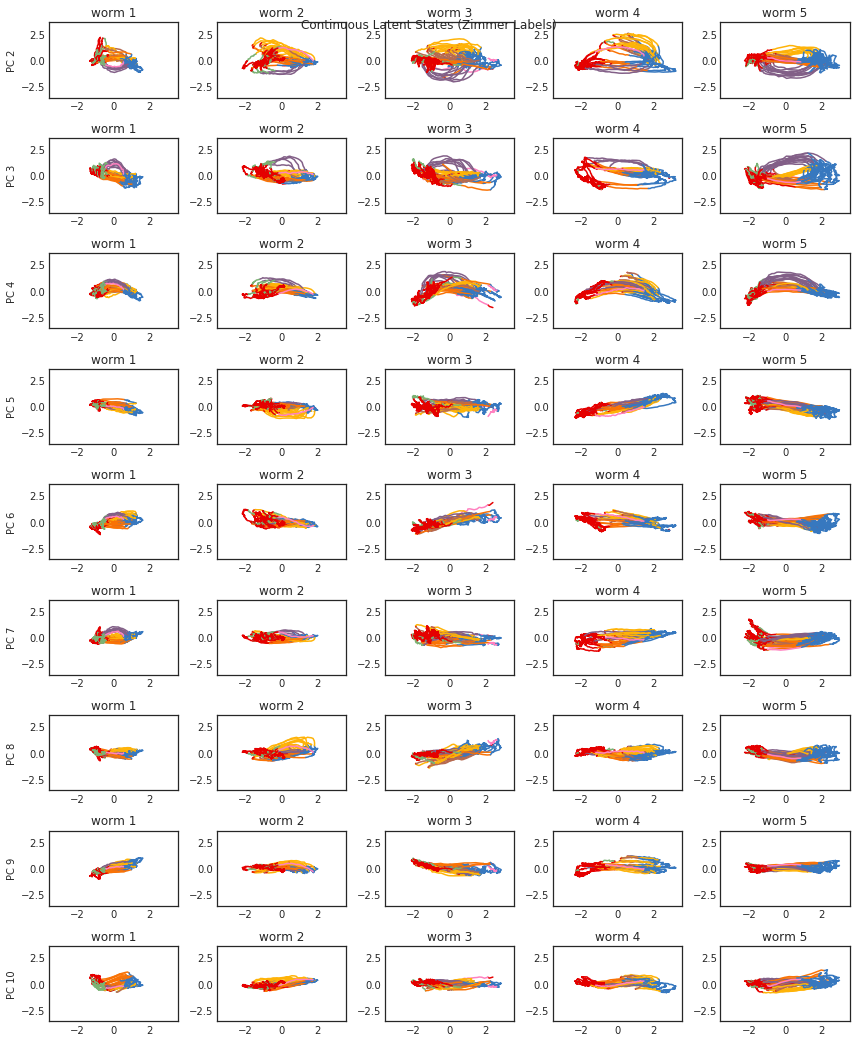

In [5]:
plt.figure(figsize=(12, 16))
for w, (x, z) in enumerate(zip(xs, z_trues)):
    for d in range(1, D):
        ax = plt.subplot(D, W, (d-1) * W + w+1)
        zplt.plot_2d_continuous_states(x, z, xlims=(-lim, lim), ylims=(-lim, lim), inds=(0, d), ax=ax)
        plt.ylabel("PC {}".format(d+1) if w == 0 else "")
        plt.title("worm {}".format(w+1))

plt.suptitle("Continuous Latent States (Zimmer Labels)")
plt.tight_layout()

# Split into train/test/validation

In [6]:
chunk = 250
train_frac = 0.7
val_frac = 0.15
all_ys = []
all_xs = []
all_ms = []
all_tags = []
all_z_trues = []
all_choices = []
for tag, (y, x, m, ztr) in enumerate(zip(ys, xs, ms, z_trues)):
    T = y.shape[0]
    C = 0
    for start in range(0, T, chunk):
        stop = min(start+chunk, T)
        all_ys.append(y[start:stop])
        all_xs.append(x[start:stop])
        all_ms.append(m[start:stop])
        all_z_trues.append(ztr[start:stop])
        all_tags.append(tag)
        C += 1
        
    # assign some of the data to train, val, and test
    choices = -1 * np.ones(C)
    choices[:int(train_frac * C)] = 0
    choices[int(train_frac * C):int((train_frac + val_frac) * C)] = 1
    choices[int((train_frac + val_frac) * C):] = 2
    choices = choices[np.random.permutation(C)]
    all_choices.append(choices)

all_choices = np.concatenate(all_choices)
get = lambda arr, chc: [x for x, c in zip(arr, all_choices) if c == chc]

train_ys = get(all_ys, 0)
train_xs = get(all_xs, 0)
train_ms = get(all_ms, 0)
train_zs = get(all_z_trues, 0)
train_tags = get(all_tags, 0)

val_ys = get(all_ys, 1)
val_xs = get(all_xs, 1)
val_ms = get(all_ms, 1)
val_zs = get(all_z_trues, 1)
val_tags = get(all_tags, 1)

test_ys = get(all_ys, 2)
test_xs = get(all_xs, 2)
test_ms = get(all_ms, 2)
test_zs = get(all_z_trues, 2)
test_tags = get(all_tags, 2)

In [7]:
print(train_tags)
print(val_tags)
print(test_tags)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[0, 0, 1, 1, 2, 2, 3, 3, 4, 4]
[0, 0, 1, 1, 2, 2, 3, 3, 4, 4]


# Fit an ARHMM to the continuous latent states

In [8]:
hmm = HMM(K, D, M, 
          transitions="recurrent", 
          observations="independent_ar", 
         )

In [9]:
# hmm = HMM(K, D, M, 
#           transitions="recurrent_only", 
#           observations="independent_ar", 
#          )

In [10]:
lls = hmm.fit(train_xs, method="em", num_em_iters=50)

Iteration 0.  LP: 189938.3
Iteration 1.  LP: 195350.3
Iteration 2.  LP: 197844.0
Iteration 3.  LP: 199256.9
Iteration 4.  LP: 199988.5
Iteration 5.  LP: 200413.2
Iteration 6.  LP: 200698.7
Iteration 7.  LP: 200910.4
Iteration 8.  LP: 201113.6
Iteration 9.  LP: 201275.2
Iteration 10.  LP: 201391.5
Iteration 11.  LP: 201464.9
Iteration 12.  LP: 201512.0
Iteration 13.  LP: 201555.2
Iteration 14.  LP: 201610.4
Iteration 15.  LP: 201663.9
Iteration 16.  LP: 201694.4
Iteration 17.  LP: 201737.2
Iteration 18.  LP: 201783.9
Iteration 19.  LP: 201787.3
Iteration 20.  LP: 201808.6
Iteration 21.  LP: 201808.1
Iteration 22.  LP: 201826.5
Iteration 23.  LP: 201859.5
Iteration 24.  LP: 201856.8
Iteration 25.  LP: 201844.5
Iteration 26.  LP: 201847.9
Iteration 27.  LP: 201856.6
Iteration 28.  LP: 201877.0
Iteration 29.  LP: 201885.3
Iteration 30.  LP: 201874.8
Iteration 31.  LP: 201889.4
Iteration 32.  LP: 201922.4
Iteration 33.  LP: 201916.3
Iteration 34.  LP: 201916.0
Iteration 35.  LP: 201949.1
It

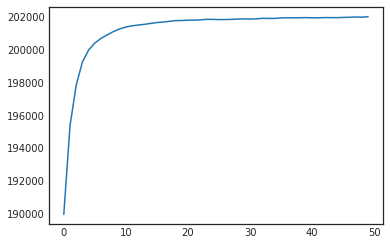

In [11]:
plt.plot(lls)

# Make a hierarchical HMM

In [12]:
# Fit a hierarchical hmm
init_state_distn = InitialStateDistribution(K, D, M)
transition_distn = HierarchicalRecurrentTransitions(K, D, W, 0, eta=1e-4)
observation_distn = HierarchicalIndependentAutoRegressiveObservations(K, D, W, 0, eta=1e-4)
hhmm = _HMM(K, D, M, init_state_distn, transition_distn, observation_distn)

# Initialize with the standard HMM
hhmm.init_state_distn.params = copy.deepcopy(hmm.init_state_distn.params)

# Copy the transition parameters
hhmm.transitions.shared_log_Ps = hmm.transitions.log_Ps.copy()
hhmm.transitions.shared_Ws = hmm.transitions.Ws.copy()
hhmm.transitions.shared_Rs = hmm.transitions.Rs.copy()

for w in range(W):
    hhmm.transitions.log_Ps[w] = hmm.transitions.log_Ps.copy()
    hhmm.transitions.Ws[w] = hmm.transitions.Ws.copy()
    hhmm.transitions.Rs[w] = hmm.transitions.Rs.copy()

# Copy the observation parameters
hhmm.observations.shared_As = hmm.observations.As.copy()
hhmm.observations.shared_Vs = hmm.observations.Vs.copy()
hhmm.observations.shared_bs = hmm.observations.bs.copy()

for w in range(W):
    hhmm.observations.As[w] = hmm.observations.As.copy()
    hhmm.observations.Vs[w] = hmm.observations.Vs.copy()
    hhmm.observations.bs[w] = hmm.observations.bs.copy()
    hhmm.observations.inv_sigmas[w] = hmm.observations.inv_sigmas.copy()

In [13]:
# # Fit a hierarchical hmm
# init_state_distn = InitialStateDistribution(K, D, M)
# transition_distn = HierarchicalRecurrentOnlyTransitions(K, D, W, 0, eta=1e-4)
# observation_distn = HierarchicalIndependentAutoRegressiveObservations(K, D, W, 0, eta=1e-4)
# hhmm = _HMM(K, D, M, init_state_distn, transition_distn, observation_distn)

# # Initialize with the standard HMM
# hhmm.init_state_distn.params = copy.deepcopy(hmm.init_state_distn.params)

# # Copy the transition parameters
# hhmm.transitions.shared_Ws = hmm.transitions.Ws.copy()
# hhmm.transitions.shared_Rs = hmm.transitions.Rs.copy()
# hhmm.transitions.shared_r = hmm.transitions.r.copy()

# for w in range(W):
#     hhmm.transitions.Ws[w] = hmm.transitions.Ws.copy()
#     hhmm.transitions.Rs[w] = hmm.transitions.Rs.copy()
#     hhmm.transitions.r[w] = hmm.transitions.r.copy()

# # Copy the observation parameters
# hhmm.observations.shared_As = hmm.observations.As.copy()
# hhmm.observations.shared_Vs = hmm.observations.Vs.copy()
# hhmm.observations.shared_bs = hmm.observations.bs.copy()

# for w in range(W):
#     hhmm.observations.As[w] = hmm.observations.As.copy()
#     hhmm.observations.Vs[w] = hmm.observations.Vs.copy()
#     hhmm.observations.bs[w] = hmm.observations.bs.copy()
#     hhmm.observations.inv_sigmas[w] = hmm.observations.inv_sigmas.copy()

In [14]:
train_lls = hhmm.fit(train_xs, tags=train_tags, method="em", num_em_iters=100, initialize=False)

Iteration 0.  LP: 200116.7
Iteration 1.  LP: 201288.7
Iteration 2.  LP: 201814.5
Iteration 3.  LP: 202115.4
Iteration 4.  LP: 202424.3
Iteration 5.  LP: 202662.6
Iteration 6.  LP: 202849.7
Iteration 7.  LP: 202992.6
Iteration 8.  LP: 203109.6
Iteration 9.  LP: 203217.9
Iteration 10.  LP: 203322.5
Iteration 11.  LP: 203422.0
Iteration 12.  LP: 203509.9
Iteration 13.  LP: 203584.7
Iteration 14.  LP: 203647.5
Iteration 15.  LP: 203698.4
Iteration 16.  LP: 203739.6
Iteration 17.  LP: 203774.8
Iteration 18.  LP: 203805.2
Iteration 19.  LP: 203832.2
Iteration 20.  LP: 203856.7
Iteration 21.  LP: 203881.4
Iteration 22.  LP: 203907.0
Iteration 23.  LP: 203933.9
Iteration 24.  LP: 203961.4
Iteration 25.  LP: 203989.0
Iteration 26.  LP: 204016.4
Iteration 27.  LP: 204046.2
Iteration 28.  LP: 204074.8
Iteration 29.  LP: 204101.0
Iteration 30.  LP: 204125.3
Iteration 31.  LP: 204147.5
Iteration 32.  LP: 204168.1
Iteration 33.  LP: 204187.8
Iteration 34.  LP: 204206.8
Iteration 35.  LP: 204226.5
It

In [15]:
hmm_val_ll = hmm.log_likelihood(val_xs, tags=val_tags)
print("HMM Validation LL:  ", hmm_val_ll)
hhmm_val_ll = hhmm.log_likelihood(val_xs, tags=val_tags)
print("HHMM Validation LL: ", hhmm_val_ll)

HMM Validation LL:   45265.12509333576
HHMM Validation LL:  46333.88916456686


# Look at inferred state segmentations

In [16]:
z_infs = [hhmm.most_likely_states(x, tag=tag) for tag, x in enumerate(xs)]
hhmm.permute(find_permutation(np.concatenate(z_trues), np.concatenate(z_infs)))
z_infs = [hhmm.most_likely_states(x, tag=tag) for tag, x in enumerate(xs)]

In [17]:
np.bincount(np.concatenate(z_infs), minlength=8)

array([2088, 3627,  774, 1456,  812,  805,  723, 1735,  599,  253, 2000,
       1324])

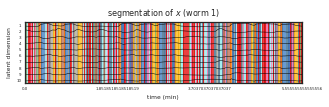

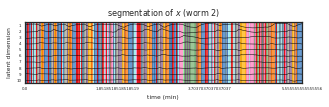

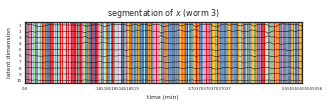

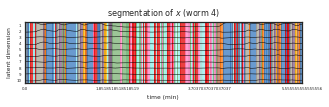

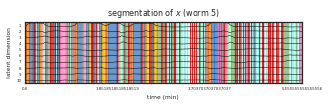

In [18]:
zplt.plot_latent_trajectories_vs_time(xs, z_infs, plot_slice=(0, 1000))

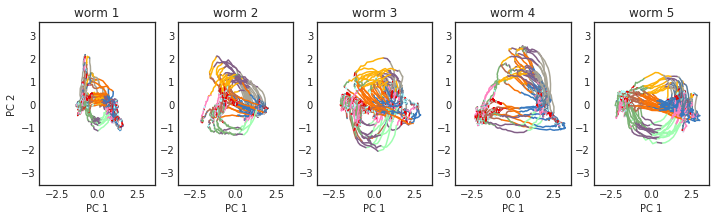

In [19]:
plt.figure(figsize=(12, 3))
for w, (x, z) in enumerate(zip(xs, z_infs)):
    ax = plt.subplot(1, W, w+1)
    zplt.plot_2d_continuous_states(x, z, xlims=(-lim, lim), ylims=(-lim, lim), inds=(0, 1), ax=ax)
    plt.ylabel("PC 2" if w == 0 else "")
    plt.xlabel("PC 1")
    plt.title("worm {}".format(w+1))
    

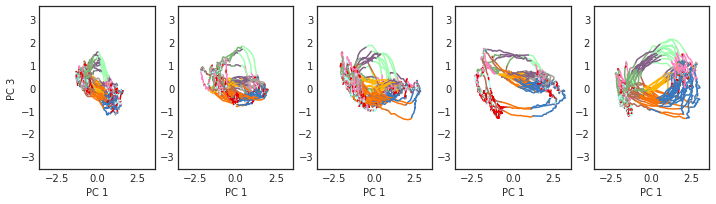

In [20]:
plt.figure(figsize=(12, 3))
for w, (x, z) in enumerate(zip(xs, z_infs)):
    ax = plt.subplot(1, W, w+1)
    zplt.plot_2d_continuous_states(x, z, xlims=(-lim, lim), ylims=(-lim, lim), inds=(0, 2), ax=ax)
    plt.ylabel("PC 3" if w == 0 else "")
    plt.xlabel("PC 1")

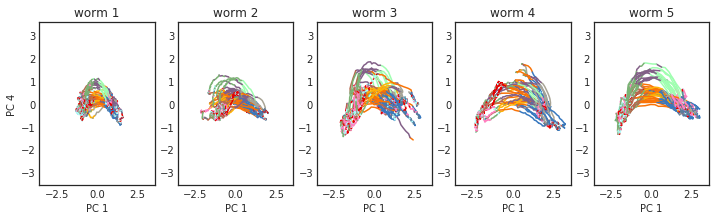

In [21]:
if D > 3:
    plt.figure(figsize=(12, 3))
    for w, (x, z) in enumerate(zip(xs, z_infs)):    
        ax = plt.subplot(1, W, w+1)
        zplt.plot_2d_continuous_states(x, z, xlims=(-lim, lim), ylims=(-lim, lim), inds=(0, 3), ax=ax)
        plt.ylabel("PC 4" if w == 0 else "")
        plt.xlabel("PC 1")    
        plt.title("worm {}".format(w+1))

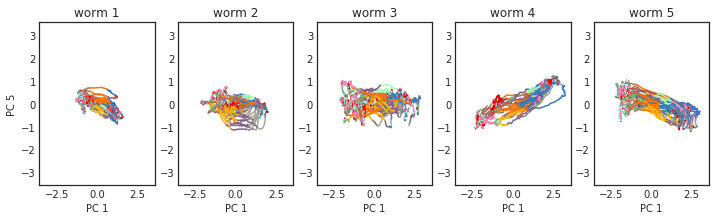

In [22]:
if D > 4:
    plt.figure(figsize=(12, 3))
    for w, (x, z) in enumerate(zip(xs, z_infs)):
        ax = plt.subplot(1, W, w+1)
        zplt.plot_2d_continuous_states(x, z, xlims=(-lim, lim), ylims=(-lim, lim), inds=(0, 4), ax=ax)
        plt.ylabel("PC 5" if w == 0 else "")
        plt.xlabel("PC 1")    
        plt.title("worm {}".format(w+1))  

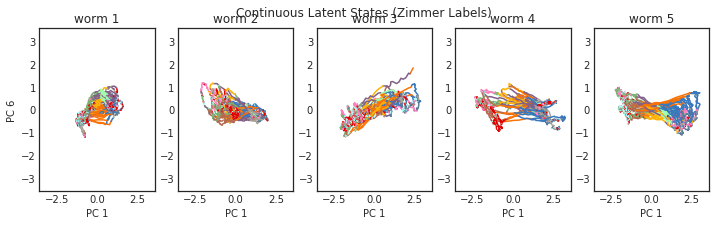

In [23]:
if D > 5:
    plt.figure(figsize=(12, 3))
    for w, (x, z) in enumerate(zip(xs, z_infs)):  
        ax = plt.subplot(1, W, w+1)
        zplt.plot_2d_continuous_states(x, z, xlims=(-lim, lim), ylims=(-lim, lim), inds=(0, 5), ax=ax)
        plt.ylabel("PC 6" if w == 0 else "")
        plt.xlabel("PC 1")    
        plt.title("worm {}".format(w+1))

    plt.suptitle("Continuous Latent States (Zimmer Labels)")

# Compare inferred and manually labeled states

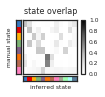

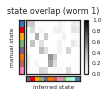

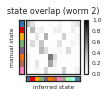

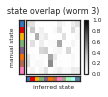

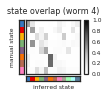

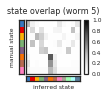

In [24]:
zplt.plot_state_overlap(z_infs, z_trues)

windows blue : REVSUS
red : SLOW
amber : VT
faded green : FWD
dusty purple : DT
orange : REV2
clay : REV1
pink : NOSTATE


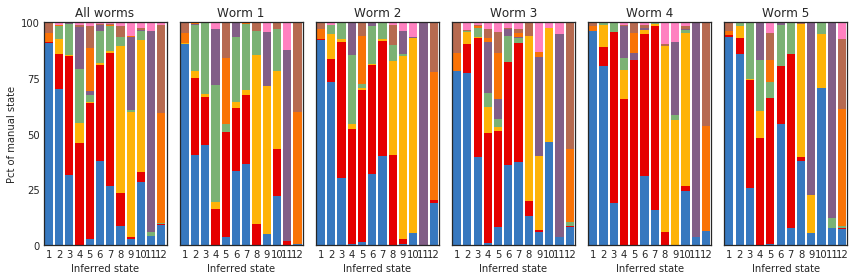

In [25]:
# Helper function to find overlap percentages
def compute_pct_overlap(zi, ztr):
    overlap = np.zeros((K, K_true))
    for k in range(K):
        overlap[k] = np.bincount(ztr[zi == k], minlength=K_true).astype(float)
        overlap[k] /= overlap[k].sum()
    return overlap

# Find a permutation so that the bar codes look progressive
total_overlap = compute_pct_overlap(np.concatenate(z_infs), np.concatenate(z_trues))
overlap_perm = np.argsort(np.argmax(total_overlap, axis=1))

# Helper function to plot "barcodes"
def plot_overlap_barcode(ax, overlap):
    for i,k in enumerate(overlap_perm):        
        for ktr in range(K_true):
            plt.bar(i, overlap[k, ktr], bottom=np.sum(overlap[k, :ktr]), color=zplt.default_colors[ktr], width=0.8)
    ax.set_xlim(-.5, K-.5)
    
# Plot all overlaps as bar codes
plt.figure(figsize=(12, 4))

# Plot the total overlap first
ax = plt.subplot(1, W+1, 1)
plot_overlap_barcode(ax, total_overlap)
plt.ylabel("Pct of manual state")
plt.yticks([0, .25, .5, .75, 1], [0, 25, 50, 75, 100])
plt.ylim(0, 1)
plt.xlabel("Inferred state")
plt.xticks(np.arange(K), np.arange(K)+1)
plt.title("All worms")

for w in range(W):
    ax = plt.subplot(1, W+1, w+2)
    overlap_w = compute_pct_overlap(z_infs[w], z_trues[w])
    plot_overlap_barcode(ax, overlap_w)
    plt.yticks([])        
    plt.ylim(0, 1)
    plt.xlabel("Inferred state")
    plt.xticks(np.arange(K), np.arange(K)+1)
    plt.title("Worm {}".format(w+1))
plt.tight_layout()

# Print key
for color_name, state_name in zip(zplt.color_names, z_true_key):
    print("{} : {}".format(color_name, state_name))

# Simulate from an HMM, reducing the dynamics noise

In [26]:
hhmm_low_noise = copy.deepcopy(hhmm)
hhmm_low_noise.observations.inv_sigmas -= 2

In [35]:
pad = 3
Tsmpl = Ts[0]
i = 1
zpre, xpre = z_infs[i][-pad:], xs[i][-pad:]
zsmpl, xsmpl = hhmm_low_noise.sample(Tsmpl, prefix=(zpre, xpre), tag=i, with_noise=True)

zfull = np.concatenate((zpre, zsmpl))
xfull = np.concatenate((xpre, xsmpl))

Text(0,0.5,'PC 3')

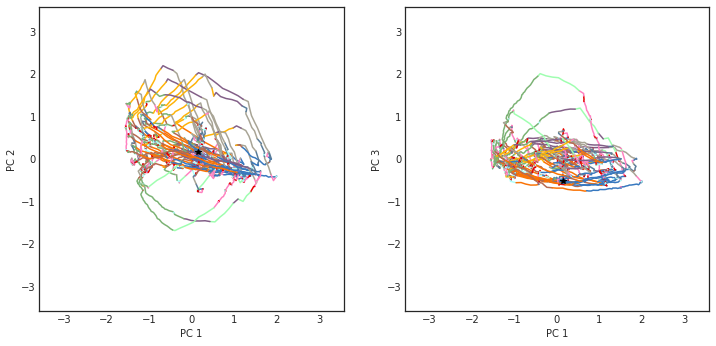

In [36]:
plt.figure(figsize=(12, 6))
ax = plt.subplot(1, 2, 1, aspect="equal")
zplt.plot_2d_continuous_states(xfull, zfull, xlims=(-lim, lim), ylims=(-lim, lim), inds=(0, 1), ax=ax)
plt.plot(xfull[pad-1,0], xfull[pad-1,1], 'k*')
plt.xlabel("PC 1")
plt.ylabel("PC 2")

ax = plt.subplot(1, 2, 2, aspect="equal")
zplt.plot_2d_continuous_states(xfull, zfull, xlims=(-lim, lim), ylims=(-lim, lim), inds=(0, 2), ax=ax)
plt.plot(xfull[pad-1,0], xfull[pad-1,2], 'k*')
plt.xlabel("PC 1")
plt.ylabel("PC 3")

Text(0.5,0,'time (s)')

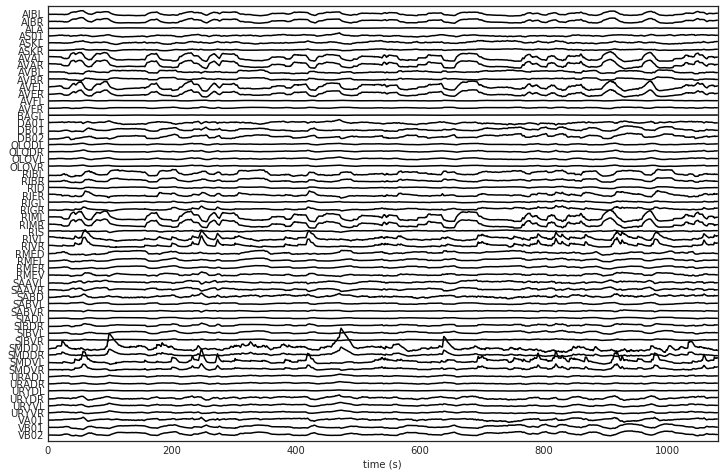

In [37]:
plt.figure(figsize=(12, 8))
ysim = xfull.dot(pca.components_) + pca.mean_
plt.plot(np.arange(ysim.shape[0]) / 3.0, ysim - np.arange(N), '-k')
plt.yticks(-np.arange(N), neuron_names)
plt.ylim(-N,1)
plt.xlim(0, ysim.shape[0] / 3.0)
plt.xlabel("time (s)")

Text(0.5,0,'time (s)')

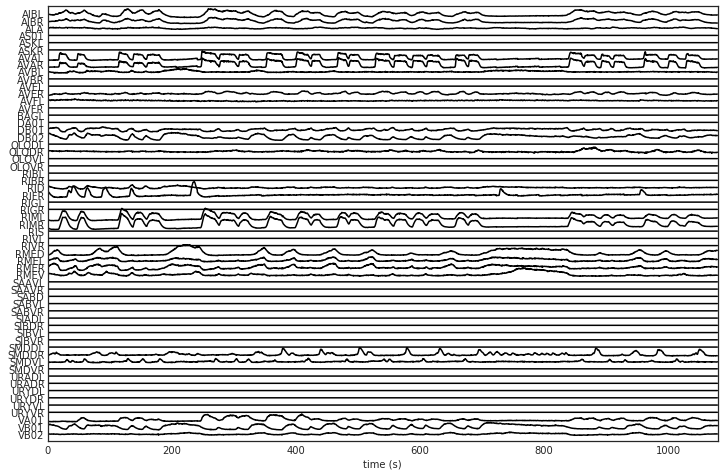

In [38]:
# Plot real data for comparison
plt.figure(figsize=(12, 8))
plt.plot(np.arange(Ts[0]) / 3.0, ys[0] - np.arange(N), '-k')
plt.yticks(-np.arange(N), neuron_names)
plt.ylim(-N,1)
plt.xlim(0, Ts[0] / 3.0)
plt.xlabel("time (s)")